<a href="https://colab.research.google.com/github/ldm2060/LearningNote/blob/main/DL%202023.6/week2/%E8%A7%86%E9%A2%91%E7%AC%94%E8%AE%B0/note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WEEK2

## 2.1 模型优化

### 2.1.1 模型优化通行步骤

```
graph TD
A[训练集Loss] -->|过大| B( )
B --> |模型偏差|C( 模型不够复杂)
B ---> |优化不好|D( 寻找最低loss 的演算法无法找到满足需要的优解)
A -->|过小| E[测试集Loss]
E -->|过大| F( )
E -->|过小| G( ^.^)
F --> |过拟合| H("模型过于满足训练数据（太灵活），不具有普遍性")
F --> |"错误匹配（Mismatching）"| I

```




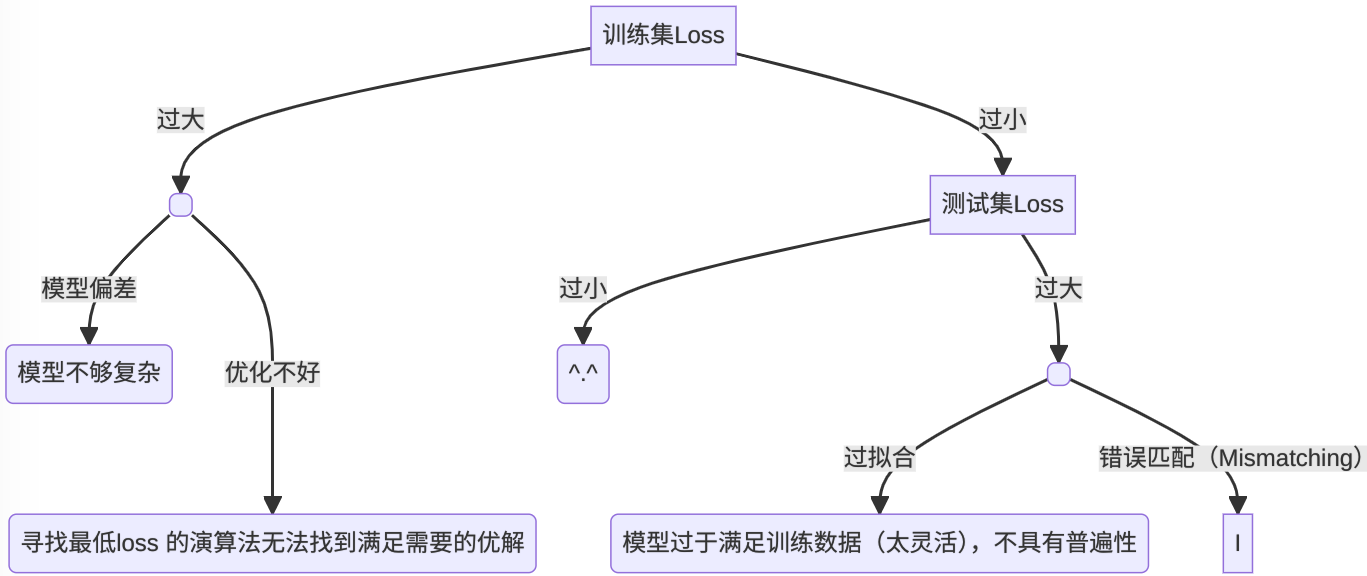

对于训练集Loss过大：

* 可以先从浅层次的模型（线性模型、SVM）起手构建，他们的优化较为简单

* DL中若更深层级的网络没有带来更小的Loss，则应考虑可能是优化性质的问题

对于过拟合问题：

* 使用更多的训练数据来训练
  * 收集更多数据
  * Data augmentation：基于已有数据进行合理变换创造新的数据
* 简化模型
  * 减少超参数等
  * less feature
  * 提前结束模型演化过程
  * 正则化（Regularization）
  * Dropout
* 限制太多，会导致回到model bias问题
* trade-off：将数据分为训练集和验证集，通过在验证集上的表现来选择模型

对于Mismatching问题：

- 通过训练集无法对测试集中出现的某些结果进行预测

- 训练集和测试集分布不一致



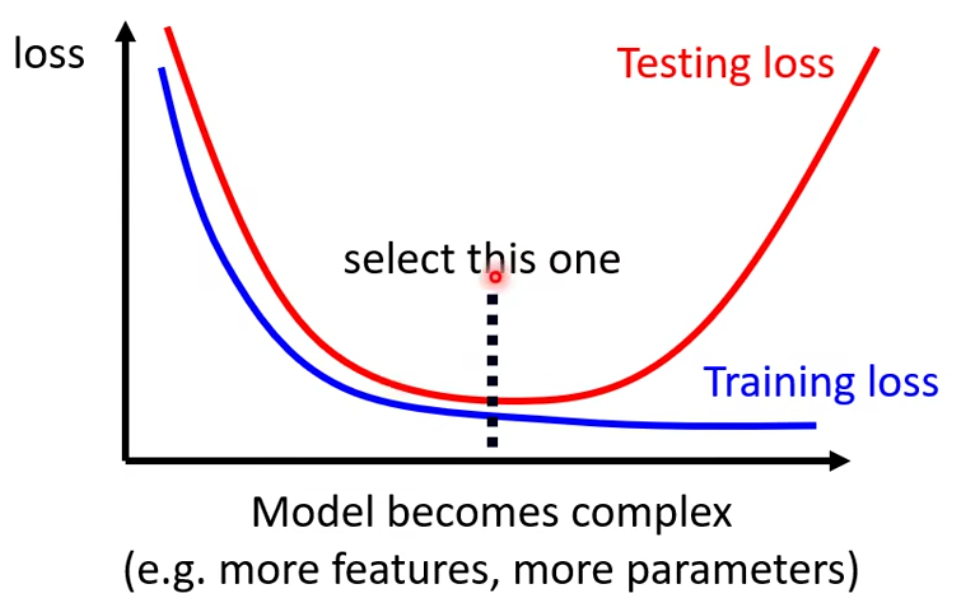